super-resolution

preparation

PyTorch is using GPU


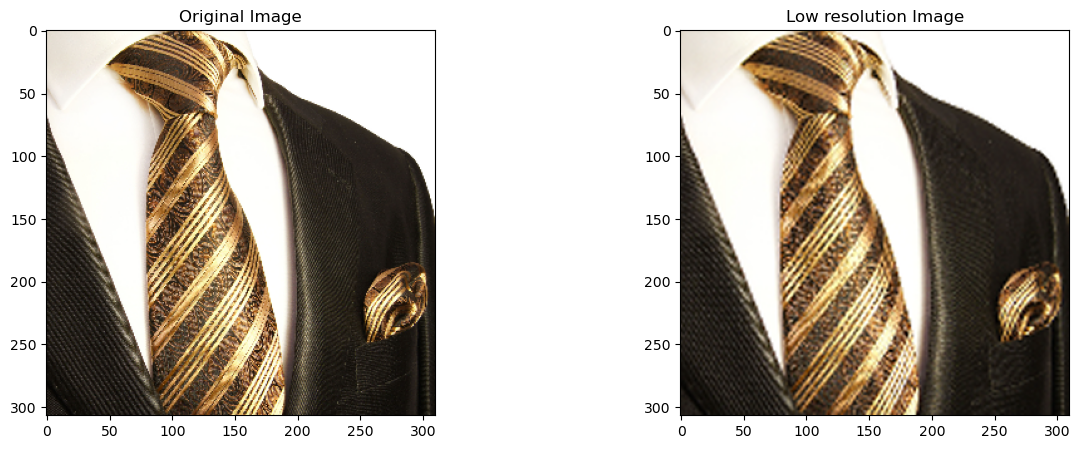

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from models import UNet, SkipModel
from search import *
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("PyTorch is using GPU")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU")

img_path  = 'data/sr/zebra_GT.png'
img_path = 'data/sr/tie.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[0], img.shape[1]
img = cv2.resize(img, (w//4, h//4), interpolation=cv2.INTER_CUBIC) # comment if image not too big (eg. not tie)
h, w = img.shape[0], img.shape[1]
scale = 2
downsampled = cv2.resize(img, (w//scale, h//scale), interpolation=cv2.INTER_CUBIC)
lr_img = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_CUBIC)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(lr_img)
axes[1].set_title('Low resolution Image')
plt.show()

In [8]:
#hyperparameters and initializations
import torch.nn as nn
input_channels = 32
epoch = 4000
lr = 0.01
reg = 0.03


# net = UNet(in_channels = input_channels)
net = SkipModel(in_channels=input_channels,                
                channels_down =[128]*5, 
                channels_up =[128]*5,
                channels_skip =[4]*5,
                upsample_mode = 'bilinear'
                )


net = net.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
noise_tensor = torch.randn(1, input_channels, h, w).to(device)
noise_tensor_saved1 = noise_tensor.detach().clone()
noise_tensor_saved2 = noise_tensor.detach().clone()

lr_img_tensor = torch.from_numpy(lr_img)[None, :]
lr_img_tensor = lr_img_tensor.permute(0, 3, 1, 2).float().to(device)
lr_img_tensor /= 255
img_tensor = torch.from_numpy(img)[None, :]
img_tensor = img_tensor.permute(0, 3, 1, 2).float().to(device)
img_tensor /= 255

iterative process

0.14803017675876617
Epoch = 0


0.002369027119129896
Epoch = 200


0.0010272490326315165
Epoch = 400


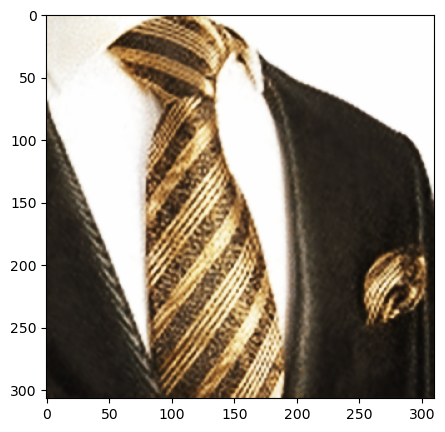

0.0006440270226448774
Epoch = 600


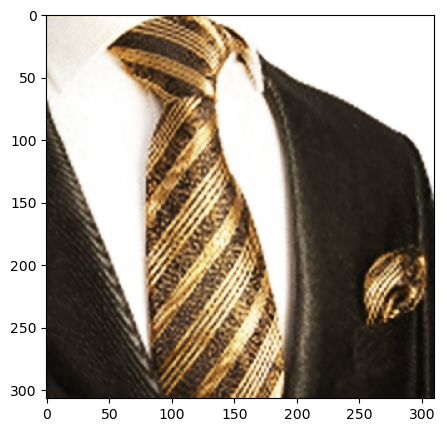

0.0004940838553011417
Epoch = 800


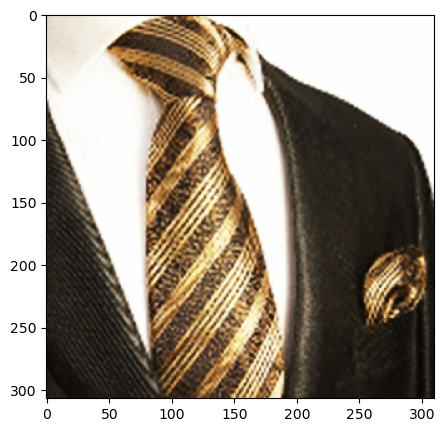

0.0003765878500416875
Epoch = 1000


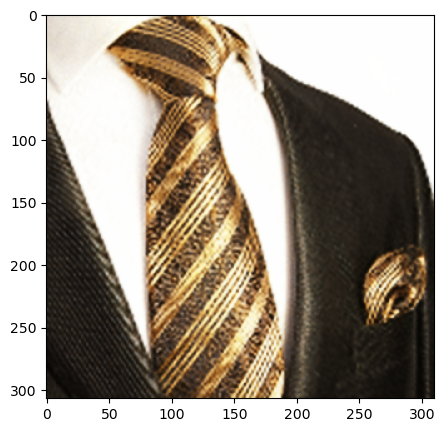

0.00031584594398736954
Epoch = 1200


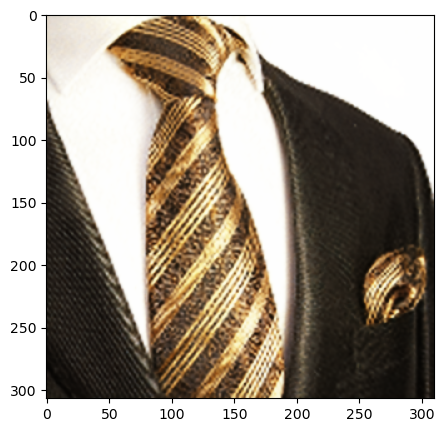

0.0002931415510829538
Epoch = 1400


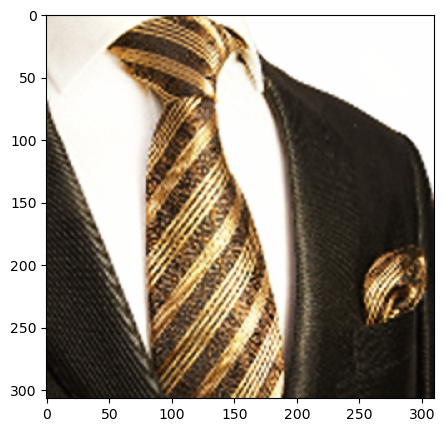

0.00021781616669613868
Epoch = 1600


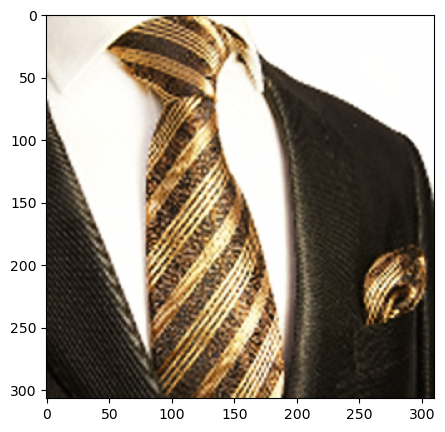

0.00018872972577810287
Epoch = 1800


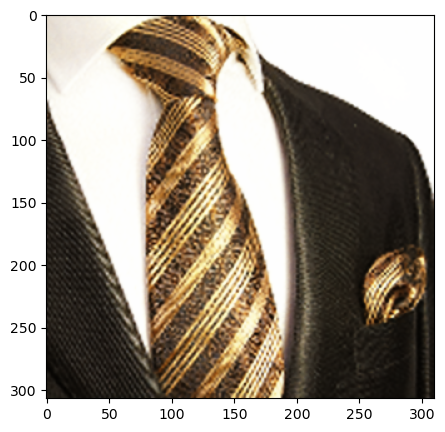

0.00016759570280555636
Epoch = 2000


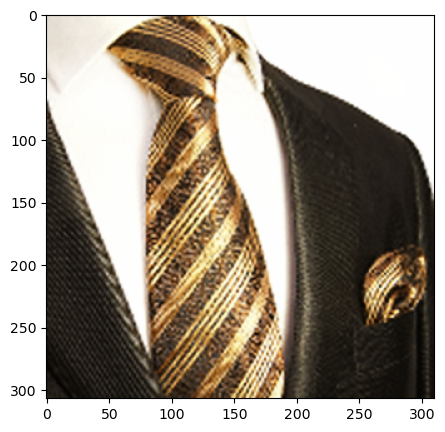

0.00015397206880152225
Epoch = 2200


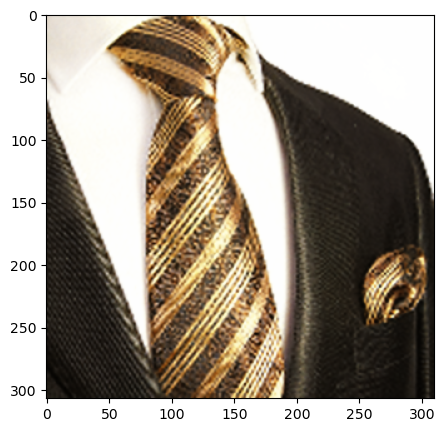

0.0001375744614051655
Epoch = 2400


0.00014747651584912091
Epoch = 2600


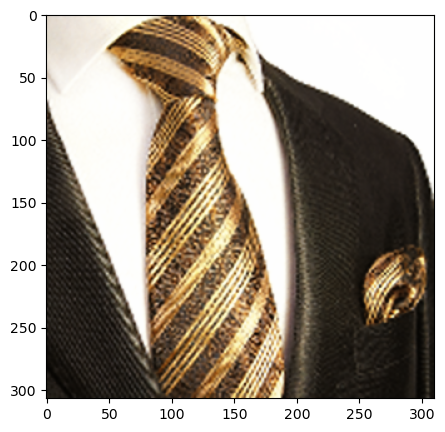

0.00012253889872226864
Epoch = 2800


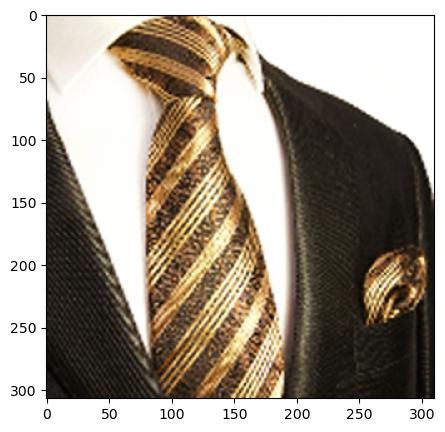

0.00010785644553834572
Epoch = 3000


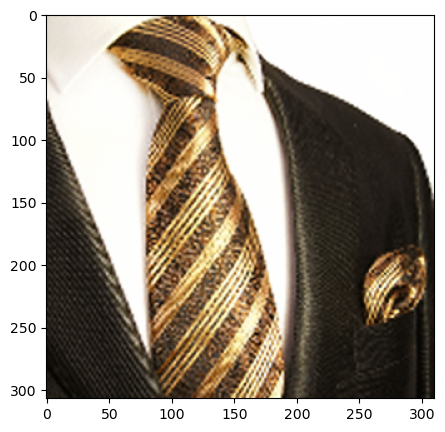

0.00012180739577161148
Epoch = 3200


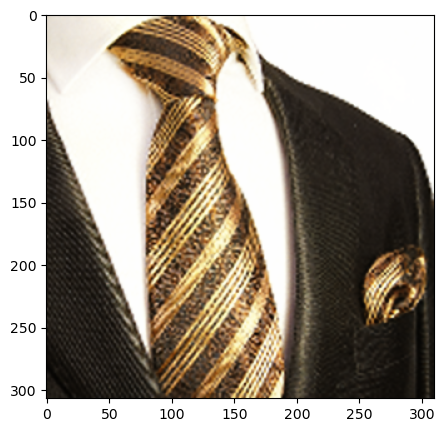

9.792733180802315e-05
Epoch = 3400


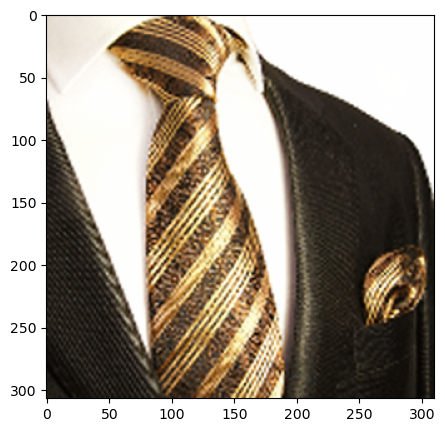

0.00010568285506451502
Epoch = 3600


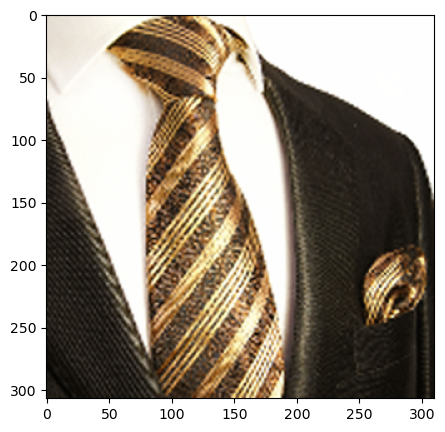

8.160640572896227e-05
Epoch = 3800


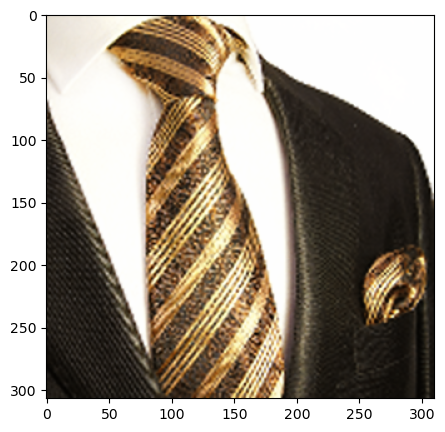

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


for i in range(epoch):
    optimizer.zero_grad()
    #regularization
    noise_tensor = noise_tensor_saved1
    if reg:
        noise_tensor = noise_tensor_saved1 + (noise_tensor_saved2.normal_() * reg)        
    noise_tensor = noise_tensor.to(device)
    output = net(noise_tensor)
    loss = criterion(output, lr_img_tensor)
    loss.backward()
    optimizer.step()
    writer.add_scalar("Super_resolution Loss", loss, i)
    if i % 200 == 0:
        print(loss.item())
        with torch.no_grad():
            output_img = output[0].detach().cpu().numpy()
            output_img = np.transpose(output_img, (1, 2, 0))        
            fig = plt.figure(figsize=(5, 5))
            print(f"Epoch = {i}")
            plt.imshow(output_img)
            plt.show()  
        